케라스 버전은 2.2.4 입니다

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 주택 가격 예측: 회귀 문제

## 보스턴 주택 가격 데이터셋

보스턴 주택 가격 데이터셋은 1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택의 가격을 예측해보기 위해 고안된 데이터셋입니다.


데이터를 살펴보겠습니다

보스턴 주택 가격 데이터셋은
총 506개의 데이터로 이루어져 있으며 각각의 데이터는 14개의 열을 가집니다.(14개의 정보를 가집니다.)이 중 404개를 Training Set으로, 102개를 Test Set으로 사용하겠습니다.
보스턴 주택 가격 데이터셋은 항목별로 스케일이 전부 다릅니다. 예를들어 범죄율의 경우 0에서 1 사이의 값을 가지며 CHAS(찰스강에 대한 더미변수)등은 0과 1의 값을 가지기도 합니다.
데이터를 가져오겠습니다.

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

트레이닝데이터는 404개로 이루어져 있습니다.

In [4]:
test_data.shape

(102, 13)

테스트 데이터는 102개로 이루어져 있습니다.

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

데이터 학습을 용이하게 하기 위한 데이터를 정규화 하는 작업입니다.

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 모델 구성


샘플의 개수가 적을수록 과대적합이 이루어지기 쉽기 때문에 모델을 작게 사용하겠습니다(64개의 유닛을 가집니다.) 모델을 작게 사용하게 되면 과대적합이 일어날 확률이 줄어듭니다.동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용하겠습니다.


In [7]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-겹 검증을 사용한 훈련 검증



데이터 수가 적기 때문에 검증Set과 훈련Set의 데이터 차이에 따라 결과가 크게 달라지기 쉽습니다. 이를 방지하기 위해 K-겹 교차 검증을 사용합니다. 데이터를 분할하여 나누고 나머지 분할에서 평가하고, 이 검증점수의 평균을 구하는 방식입니다.
여기서는 K를 4로 하여 4번 분할하였습니다.

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

W0729 21:49:08.045265 15920 deprecation_wrapper.py:119] From C:\Users\yhkim\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 21:49:08.088213 15920 deprecation_wrapper.py:119] From C:\Users\yhkim\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 21:49:08.093284 15920 deprecation_wrapper.py:119] From C:\Users\yhkim\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 21:49:08.166828 15920 deprecation_wrapper.py:119] From C:\Users\yhkim\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



처리중인 폴드 # 0


W0729 21:49:08.595947 15920 deprecation_wrapper.py:119] From C:\Users\yhkim\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0729 21:49:08.609652 15920 deprecation_wrapper.py:119] From C:\Users\yhkim\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [9]:
all_scores

[2.0836660578699395,
 2.1494157880839735,
 2.9265254039575557,
 2.3963802822745675]

각각의 스코어는 다음과 같습니다.

In [10]:
np.mean(all_scores)

2.388996883046509

평균은 2.38정도 나오게 됩니다. 이러한 차이는 각각의 차이보다 신뢰도를 높여준다고 할 수 있습니다.(평균을 구하기 전에는 2.08에서 2.92까지 다양)

아직도 차이가 크기 때문에 효율을 높이기 위해 500 에포크동안 훈련 해보겠습니다.

In [11]:
from keras import backend as K

# 메모리 해제
K.clear_session()

처음부터 시작하기 위해 세션을 Clear하겠습니다.

In [12]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [13]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

<Figure size 640x480 with 1 Axes>

이 그래프는 범위가 크고 변동이 심하기 때문에 보기가 좀 어렵습니다.

이를 편하게 보기 위해 다음과같은 처리를 하겠습니다.

* 곡선의 다른 부분과 스케일이 많이 다른 첫 10개 데이터 포인트를 제외시킵니다.
* 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균으로 대체합니다.

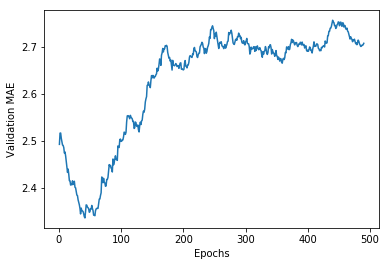

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

그래프를 확인하면 사실상 80에포크 정도 후부터는 과대적합이 시작되는것을 확인할 수 있습니다. 이 정보를 통해 80회 에포크를 해 테스트를 해보겠습니다.

In [17]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [18]:
test_mae_score

2.675054858712589

에포크 80으로 학습 결과
##2.6750달러정도의 차이를 보였습니다.